In [23]:
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from nomination_predictor.config import INTERIM_DATA_DIR

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
    
sns.set_theme(style="whitegrid")
%matplotlib inline


In [ ]:
import pandas as pd

from nomination_predictor.config import INTERIM_DATA_DIR

df = pd.read_csv(INTERIM_DATA_DIR / "feature_engineered.csv")

In [ ]:
df['days_nom_to_latest_action'].describe()

count    1416.000000
mean      146.310734
std       124.659988
min         0.000000
25%        58.000000
50%       118.000000
75%       192.000000
max       727.000000
Name: days_nom_to_latest_action, dtype: float64

/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


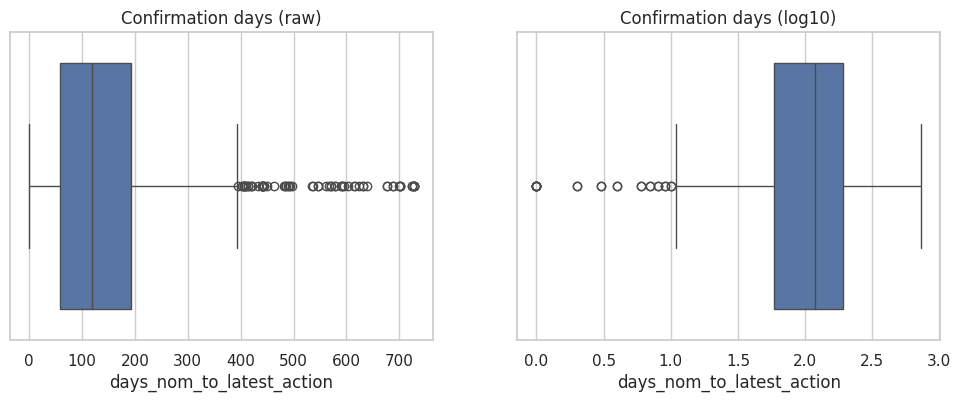

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(x=df['days_nom_to_latest_action'], ax=axes[0])
axes[0].set_title('Confirmation days (raw)')
    
sns.boxplot(x=np.log10(df['days_nom_to_latest_action']), ax=axes[1])
axes[1].set_title('Confirmation days (log10)')
plt.show()

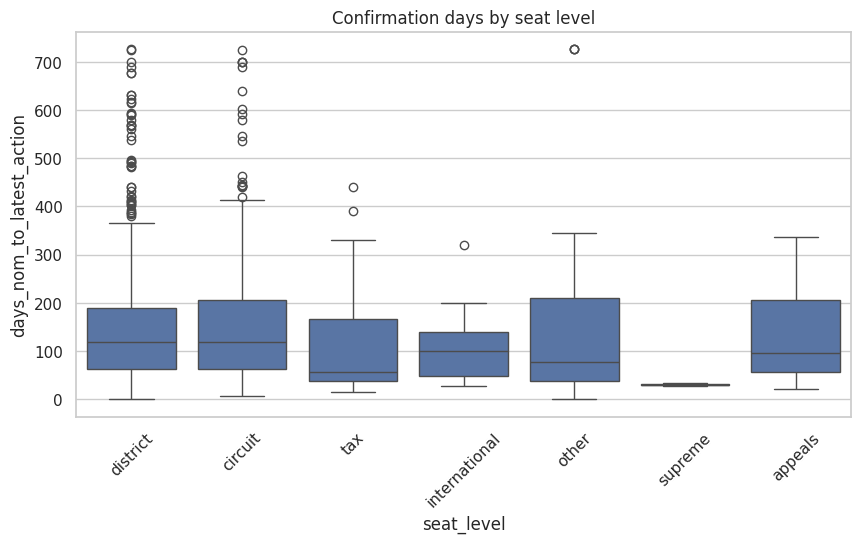

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='seat_level', y='days_nom_to_latest_action')
plt.xticks(rotation=45)
plt.title('Confirmation days by seat level')
plt.show()

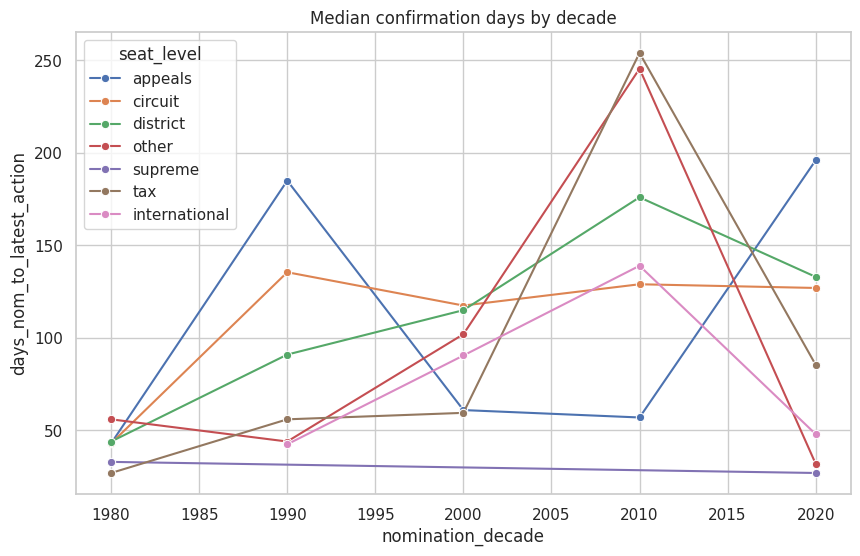

In [ ]:
df['nomination_year'] = pd.to_datetime(df['receiveddate']).dt.year
df['nomination_decade'] = (df['nomination_year'] // 10) * 10
dec_pivot = df[df['days_nom_to_latest_action'].notna()].groupby(['nomination_decade','seat_level'])['days_nom_to_latest_action'].median().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=dec_pivot, x='nomination_decade', y='days_nom_to_latest_action', hue='seat_level', marker='o')
plt.title('Median confirmation days by decade')
plt.show()

## Visualizing where we may be lacking data

Some of these columns make sense to be blank (not every judge has 5 degrees and has thee different reappointments on record) so the part we're wanting to reassure ourselves about is that we do have enough data in the columns we care about.

For example, discovering we lack birth days and months is part of what led to the upstream feature-engineering cell using middle-of-year to calculate judge ages as of nominations.

Either of these visualizations is based on a semi-random sampling of the total dataframe.

<Axes: >

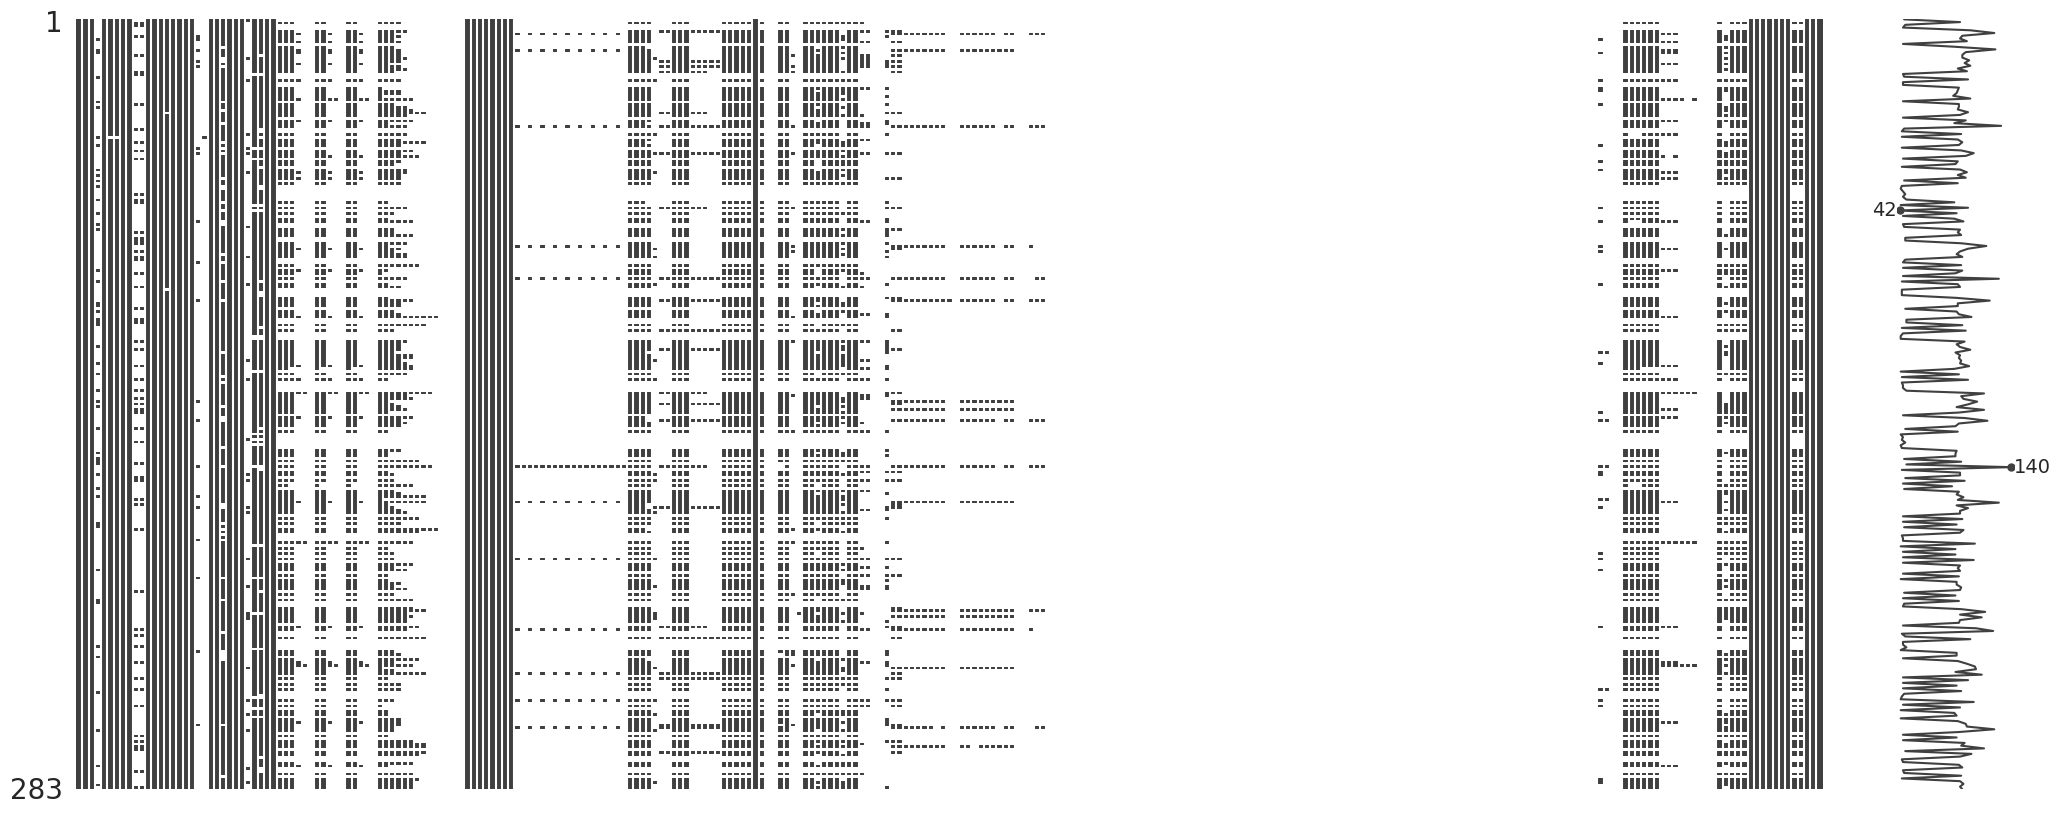

In [ ]:
import missingno as msno

MSNO_SAMPLE_SIZE = int(len(df)*0.2)
msno.matrix(df.sample((MSNO_SAMPLE_SIZE))) # long-zoom-out-of-spreadsheet-like visualization indicating for a sampling of our dataframe, where there's data vs. where it's absent

<Axes: >

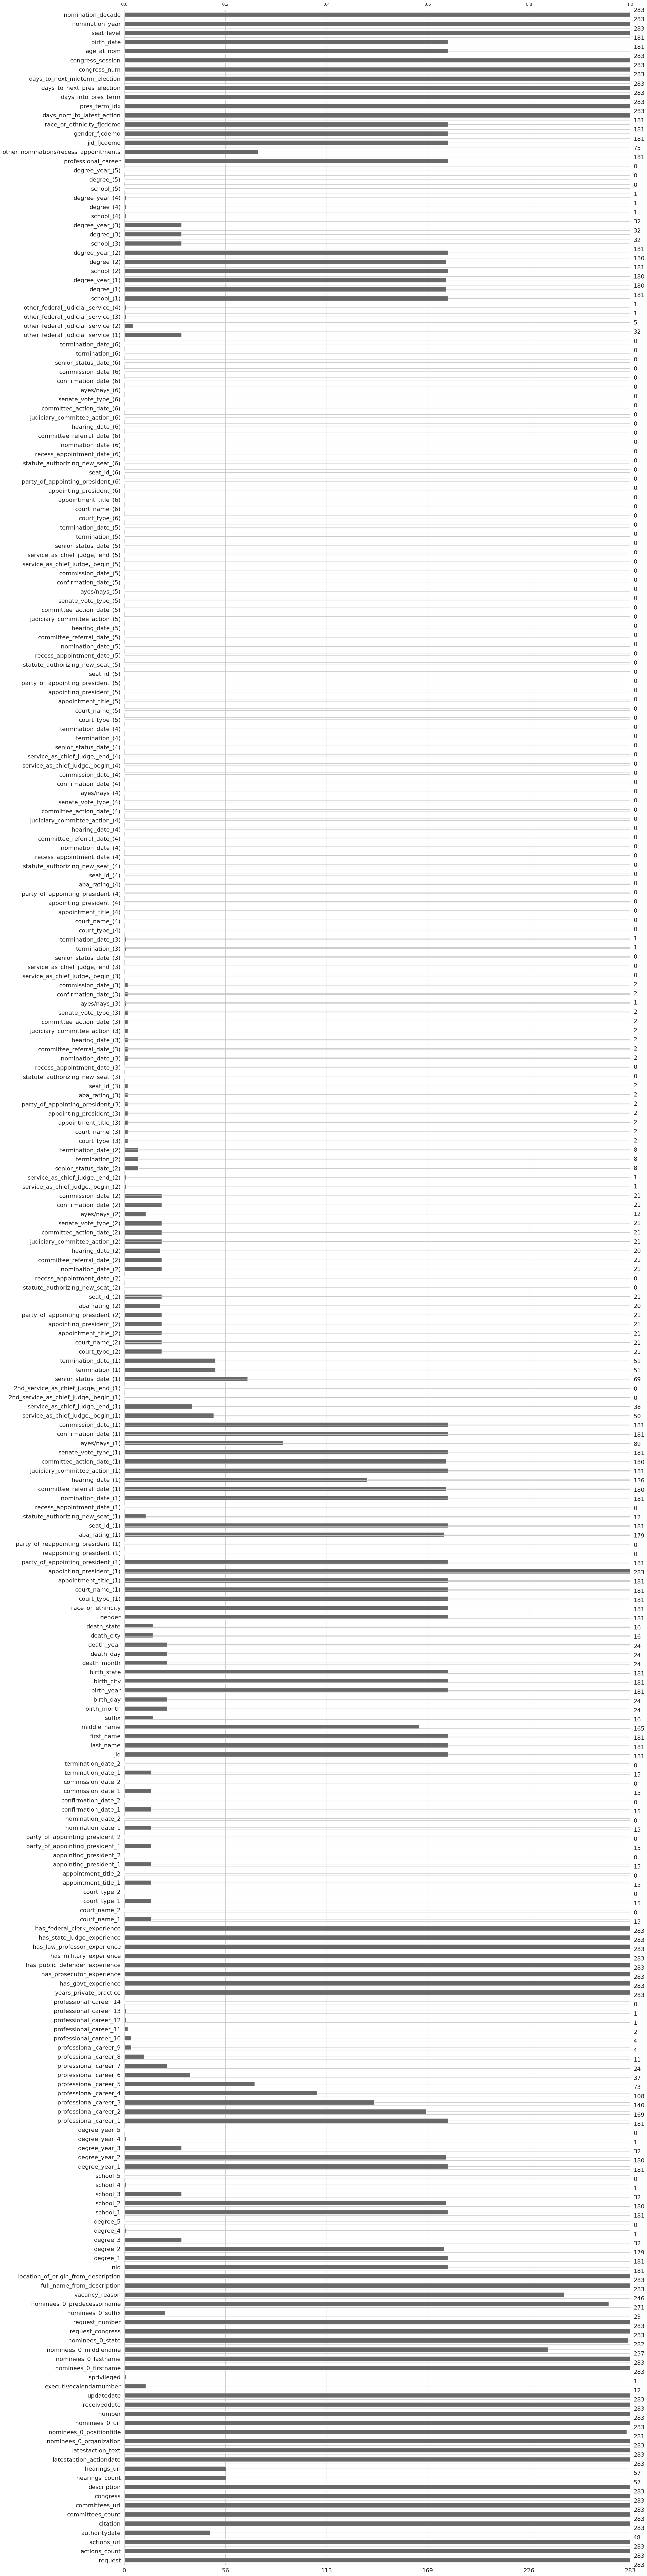

In [ ]:
msno.bar(df.sample(MSNO_SAMPLE_SIZE)) # horizontal bar chart indicating for a given sampling of dataframe, how many of those do have data vs. don't

In [ ]:
msno.heatmap(df)

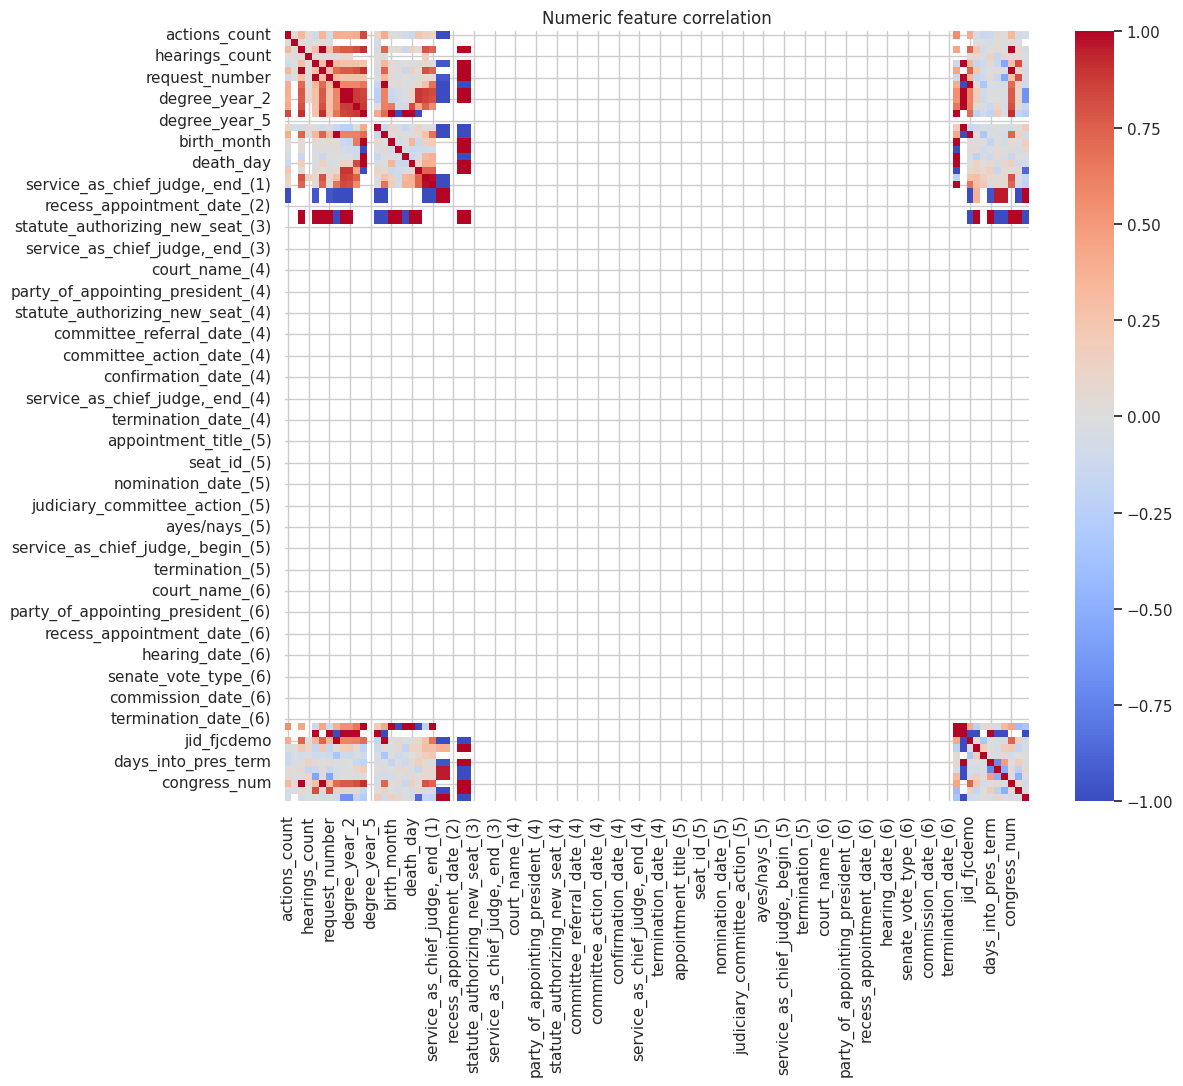

In [ ]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title('Numeric feature correlation')
plt.show()

## Simple visualizations


Visualizing seat level distribution:


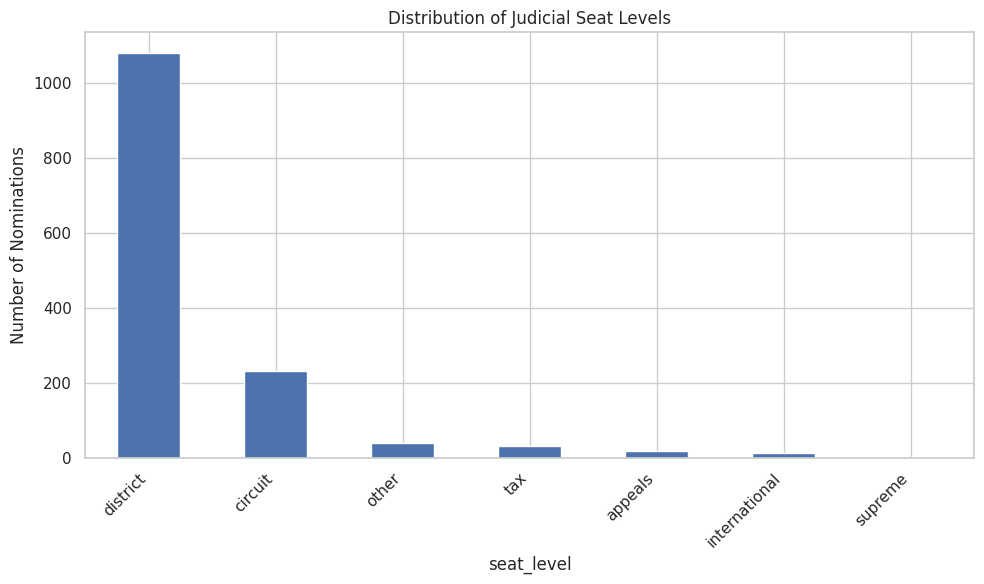

In [ ]:
# Visualization of seat level distribution
print("\nVisualizing seat level distribution:")
import matplotlib.pyplot as plt

df["seat_level"].value_counts().plot(
    kind="bar", 
    figsize=(10, 6), 
    title="Distribution of Judicial Seat Levels"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Nominations")
plt.tight_layout()
plt.show()

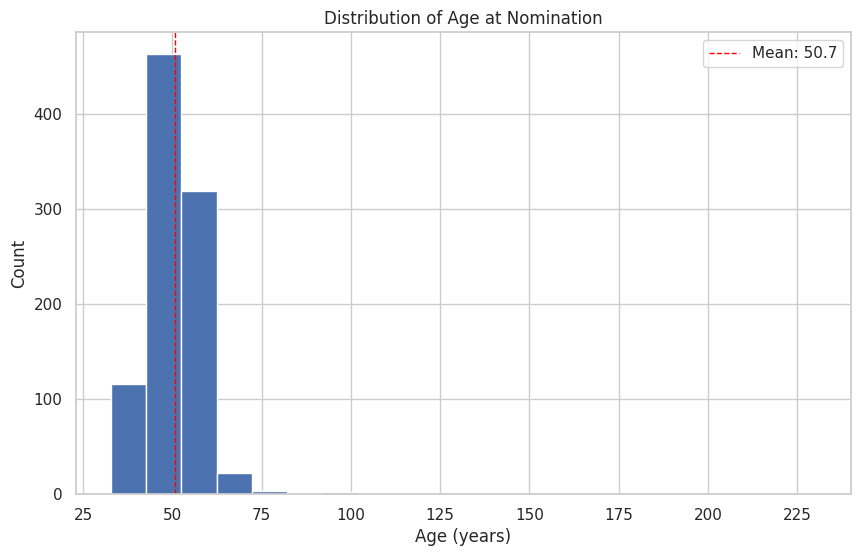

In [ ]:
# visualization of age distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['age_at_nom'].hist(bins=20)
plt.title('Distribution of Age at Nomination')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.axvline(df['age_at_nom'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {df["age_at_nom"].mean():.1f}')
plt.legend()
plt.show()

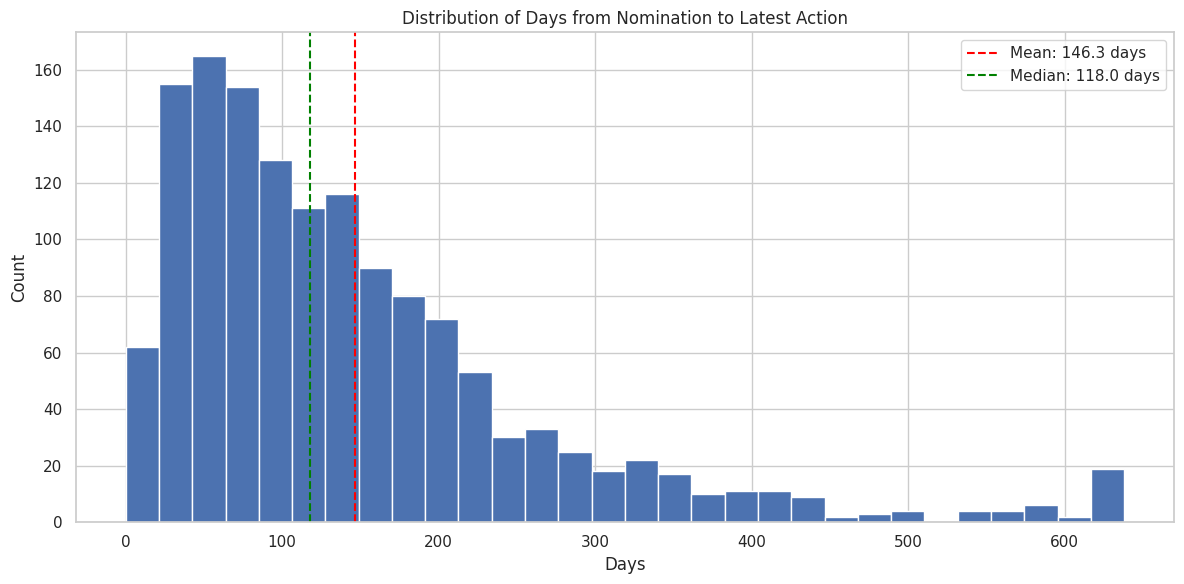

In [ ]:
# days from nomination to last senate action
# Visualization of the distribution
plt.figure(figsize=(12, 6))

# Using clipping to make the histogram more readable (excluding extreme outliers)
days_series = df['days_nom_to_latest_action'].dropna()
q99 = days_series.quantile(0.99)  # 99th percentile

plt.hist(days_series.clip(upper=q99), bins=30)
plt.axvline(days_series.mean(), color='red', linestyle='dashed', 
            label=f'Mean: {days_series.mean():.1f} days')
plt.axvline(days_series.median(), color='green', linestyle='dashed', 
            label=f'Median: {days_series.median():.1f} days')

plt.title('Distribution of Days from Nomination to Latest Action')
plt.xlabel('Days')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Show a table of typical durations by outcome
if 'latestaction' in df.columns:
    print("\nMedian days by latest action type:")
    action_days = df.groupby('latestaction')['days_nom_to_latest_action'].median().sort_values()
    for action, days in action_days.items():
        count = df[df['latestaction'] == action].shape[0]
        print(f"- {action}: {days:.1f} days ({count} nominations)")

## Prior rougher attempt

In [ ]:

## pick target and drop rows lacking it
#y = df["days_vac_to_nom"]
#X = df.drop(columns=["days_vac_to_nom",
#                     "days_nom_to_latest_action",     # other targets saved for later tasks
#                     "days_vac_to_conf"])
#
## --------  column groups ------------
#num_cols = [
#    "age_at_nom", "days_into_pres_term",
#    "days_to_next_pres_elec", "days_to_next_mid_elec",
#    "congress_num", "years_private_practice",
#    "highest_degree_level"
#] + [c for c in df.columns if c.startswith("years_")]
#
#bool_cols = [c for c in df.columns if c.startswith("has_")] + ["partisan_mismatch"]
#
#cat_cols = [
#    "pres_term_idx", "congress_session",
#    "seat_level", "vacancy_reason_cat",
#    "pres_party", "party_of_appointing_president"
#]
#
## --------  preprocessors -------------
#preprocessor = ColumnTransformer(
#    transformers=[
#        ("num",  SimpleImputer(strategy="median"), num_cols + bool_cols),
#        ("cat",  OneHotEncoder(handle_unknown="ignore"), cat_cols)
#    ],
#    remainder="drop"
#)
#
## --------  XGBoost regressor ----------
#xgb_reg = xgb.XGBRegressor(
#    n_estimators=600,
#    learning_rate=0.05,
#    max_depth=6,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    objective="reg:squarederror",
#    random_state=42
#)
#
#model = Pipeline(steps=[
#    ("prep", preprocessor),
#    ("xgb",  xgb_reg)
#])
#
## --------  train / validate -----------
#from sklearn.model_selection import cross_val_score, train_test_split
#
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
#model.fit(X_train, y_train)
#print("Test MAE:", abs(model.predict(X_test) - y_test).mean())